In [250]:
### Sentence Embeddings, Clustering, and Summarization
import pandas as pd
import numpy as np
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import torch
from transformers import pipeline
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [251]:
# Necessary resources  
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/monserrat.lopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monserrat.lopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [252]:
# Load preprocessed environmental feedback dataset
feedback_env = pd.read_csv("../data/processed/feedback_environmental_filtered.csv")
w2v_model = Word2Vec.load("../data/processed/word2vec_feedback_env.model")

In [253]:
# Tokenize sentences  
def tokenize_sentences(text):
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in text.lower().split() if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    return ''

if 'tokenized_sentences' not in feedback_env.columns:
    feedback_env['tokenized_sentences'] = feedback_env['env_sentences'].apply(tokenize_sentences)


In [254]:
# Generate sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if words:
        return np.mean([model.wv[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)

feedback_env = feedback_env.copy()
feedback_env.loc[:, 'embedding'] = feedback_env['tokenized_sentences'].apply(
    lambda x: get_sentence_embedding(x.split(), w2v_model)
)

In [268]:
# Apply UMAP dimensionality reduction
embeddings_matrix = np.vstack(feedback_env['embedding'].values)
reduced_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings_matrix)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
feedback_env.loc[:, 'cluster'] = kmeans.fit_predict(reduced_embeddings)

# Save clustered data
feedback_env.to_csv("../data/processed/feedback_environmental_with_clusters.csv", index=False)
print("Clustering completed and dataset saved!")

/Users/monserrat.lopez/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/monserrat.lopez/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering completed and dataset saved!


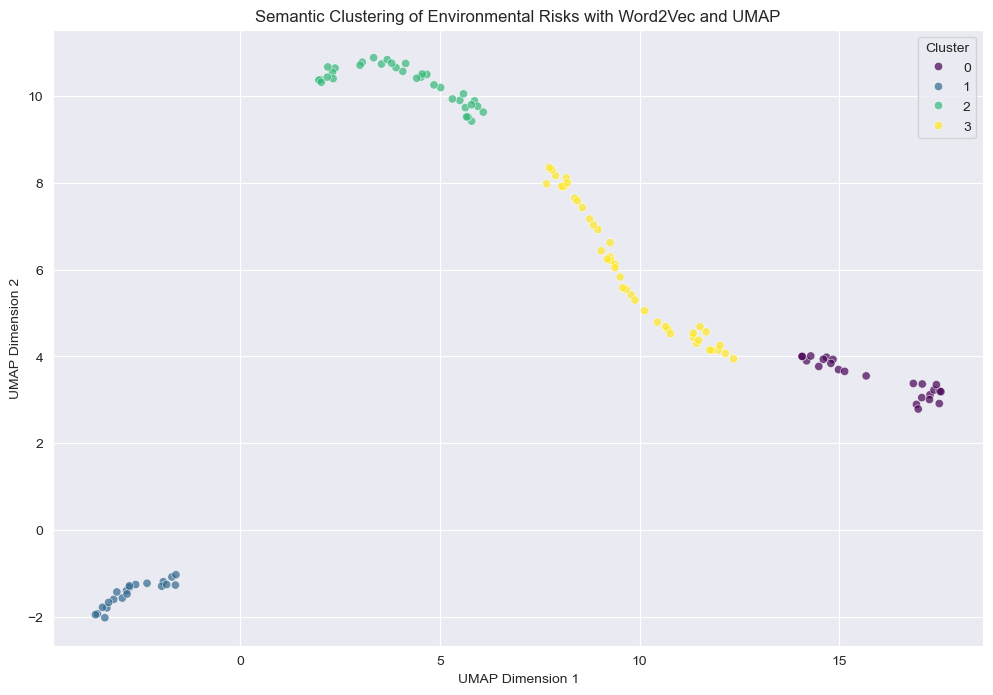

In [269]:
# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=feedback_env['cluster'],
    palette='viridis',
    alpha=0.7
)
plt.title('Semantic Clustering of Environmental Risks with Word2Vec and UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()

In [270]:
# Display representative sentences per cluster
for cluster_id in sorted(feedback_env['cluster'].unique()):
    print(f"\nCluster {cluster_id} Representative Sentences:")
    sample_sentences = feedback_env[feedback_env['cluster'] == cluster_id]['env_sentences'].dropna().sample(3,
                                                                                                            random_state=42).tolist()
    for idx, sentence in enumerate(sample_sentences, 1):
        print(f"{idx}. {sentence}")


Cluster 0 Representative Sentences:
1. This is necessary to ensure that AI practices are prohibited and fully protected with necessary and proportionate safeguards based on their perceived harm , including environmental harm . We know that machine learning is data hungry, and that data processing requires a high level of energy consumption. Whilst some AI can be used to help reduce carbon footp rint and to lower energy consumption, other AI can put a heavy burden on the environment. An environmental impact is high -risk and must also be considered in the impact assessment of AI. Environmental impact As highlighted above, Al can reduce negative impact to the environment, but can also contribute to it.
2. The document is therefore structured as follows : Scope and impact of the draft AI Regulation Data and Data governance for AI Notion and components of trustworthiness in the AI Regulation Risk-assessment and risk classification Balance innovation - regulation and elements of supporting

In [271]:
# Identify Top Words per Cluster
for cluster_id in feedback_env['cluster'].unique():
    cluster_texts = feedback_env[feedback_env['cluster'] == cluster_id]['env_sentences'].fillna('')
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    cluster_bow = vectorizer.fit_transform(cluster_texts)
    top_words = vectorizer.get_feature_names_out()
    print(f"Cluster {cluster_id} Top Words: {top_words}")

Cluster 2 Top Words: ['ai' 'climate' 'development' 'energy' 'environmental' 'human'
 'sustainability' 'sustainable' 'systems' 'use']
Cluster 1 Top Words: ['ai' 'approval' 'authority' 'energy' 'european' 'footprint' 'healthcare'
 'member' 'rules' 'sector']
Cluster 3 Top Words: ['ai' 'change' 'climate' 'data' 'energy' 'environmental' 'european' 'high'
 'sustainability' 'systems']
Cluster 0 Top Words: ['ai' 'banks' 'data' 'energy' 'environmental' 'european' 'operative'
 'regulation' 'sustainability' 'systems']


### Cluster Summarization

In [272]:
# Check GPU availability and set the device
device = 0 if torch.cuda.is_available() else -1
print(f"Using {'GPU' if torch.cuda.is_available() else 'CPU'} for summarization.")

# Load summarizer with GPU support
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)


# Sentence and Token-Based Chunking
def chunk_text(text, max_tokens=500):
    """
    Splits text into smaller chunks based on sentence boundaries 
    and ensures token count stays below max_tokens.
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())
        if current_length + sentence_length > max_tokens:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
            current_length = sentence_length
        else:
            current_chunk.append(sentence)
            current_length += sentence_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks


# Summarize each cluster with chunking
def summarize_cluster(cluster_text):
    """
    Summarizes a list of sentences by splitting them into chunks 
    and summarizing each chunk individually.
    """
    combined_text = ' '.join(cluster_text)
    text_chunks = chunk_text(combined_text, max_tokens=500)
    summaries = []

    for chunk in text_chunks:
        try:
            max_len = min(100, len(chunk.split()))
            min_len = min(25, max_len // 2)
            summary = summarizer(chunk, max_length=max_len, min_length=min_len, do_sample=False)
            summaries.append(summary[0]['summary_text'])
        except Exception as e:
            print(f"Error summarizing chunk: {e}")
            summaries.append("Chunk Summarization Failed")

    return ' '.join(summaries)


Using CPU for summarization.


In [273]:
# Summarize each cluster
cluster_summaries = {}
for cluster_id in sorted(feedback_env['cluster'].unique()):
    print(f"\nSummarizing Cluster {cluster_id}...")
    cluster_text = feedback_env.loc[feedback_env['cluster'] == cluster_id, 'env_sentences'].dropna().tolist()
    if not cluster_text:
        cluster_summaries[cluster_id] = "No valid sentences in this cluster."
    else:
        try:
            cluster_summaries[cluster_id] = summarize_cluster(cluster_text)
        except Exception as e:
            print(f"Error summarizing cluster {cluster_id}: {e}")
            cluster_summaries[cluster_id] = "Summarization Failed"


Summarizing Cluster 0...

Summarizing Cluster 1...

Summarizing Cluster 2...

Summarizing Cluster 3...


In [274]:
# Display Cluster Summaries
for cluster_id, summary in cluster_summaries.items():
    print(f"\n **Cluster {cluster_id} Summary:**\n{summary}\n")


 **Cluster 0 Summary:**
Enel SpA, a multinational company in the energy sector, highly appreciates the EC proposal for a legal act laying down requirements for Artificial Intelligence. European health systems are facing major challenges related to the sustainability and quality of healthcare provision. E.ON calls for a priority focus on any AI use case with a benefit for climate and the environment. The Act should focus as well on leveraging the use of AI to mitigate the risks of climate change. AstraZeneca develops and uses AI technology in line with its Principles for Ethical Data and AI (see Annex) The use of AI systems in regulated measuring instruments is now envisaged by the manufacturers of these products. The EACB trusts that its comments will be taken into account. We believe that overlapping or conflicting regulation needs to be avoided and sector -specific legislation such as the CRR should prevail. The effects of AI on social and environmental aspects should also be examin